# Fish Species Classification using CNN

Mô hình CNN để phân loại loài cá từ 2 bộ dữ liệu:
- Fishnet Image Library
- BBox Dataset

Các bước:
1. Nhập dữ liệu với label tự động từ tên thư mục
2. Resize ảnh 224x224 và tiền xử lý
3. Huấn luyện CNN
4. Dự đoán loài cá
5. Trực quan hóa kết quả

In [21]:
# Kiểm tra GPU để tối ưu
!nvidia-smi  # Xem GPU type & memory
!nvidia-smi dmon -s puc -c 1  # Monitor real-time

Sun Nov 30 06:12:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             32W /  250W |    4399MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Tối ưu GPU

In [22]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Tắt warning

# import tensorflow as tf
# print(f"TensorFlow version: {tf.__version__}")

# # CẤU HÌNH GPU TRƯỚC KHI KHỞI TẠO TensorFlow
# gpus = tf.config.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)
# #tf.config.optimizer.set_jit_compilation_enabled(True)

## Nhập dữ liệu

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import cv2

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Nhập dữ liệu

In [24]:
!pip install -q gdown

In [25]:
# Tải file từ Google Drive về thư mục làm việc hiện tại (/kaggle/working)
!gdown --id 1NyBwDXcF069an5qVoeQCVLZLM4iVlQ6T -O fishnet.zip -q

# Tạo thư mục và unzip
!mkdir -p processed_fish
!unzip -o -q fishnet.zip -d processed_fish


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [26]:
!ls -lh


total 2.0G
drwxr-xr-x   2 root root 4.0K Nov 30 05:53 best_model2
-rw-r--r--   1 root root 2.0G Nov 29 13:43 fishnet.zip
drwxr-xr-x 465 root root  20K Nov 30 05:52 processed_fish


In [27]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def load_data_from_directory(data_path, img_size=(224, 224)):

    print("="*60)
    print("BƯỚC 1: NHẬP DỮ LIỆU")
    print("="*60 + "\n")

    # Tạo ImageDataGenerator cho training với augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,        # Xoay ảnh 20 độ
        width_shift_range=0.2,    # Dịch ngang 20%
        height_shift_range=0.2,   # Dịch dọc 20%
        horizontal_flip=True,     # Lật ngang
        zoom_range=0.2,           # Phóng to/nhỏ 20%
        fill_mode='nearest'
    )

    # Tạo ImageDataGenerator cho validation/test
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    batch_size = 64

    # Load dữ liệu từ thư mục theo từng batch
    train_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        subset='training'
    )

    val_generator = val_datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        subset='validation'
    )

    print(f"\nDữ liệu từ folder: {data_path}")
    print(f"  - Số lớp: {train_generator.num_classes}")
    print(f"  - Training samples: {train_generator.samples}")
    print(f"  - Validation samples: {val_generator.samples}")
    print(f"  - Batch size: {batch_size}")

    label_map = {v: k for k, v in train_generator.class_indices.items()}
    print(f"  - Label: {list(label_map.values())[:5]}... ({len(label_map)} loài)\n")

    return train_generator, val_generator, label_map, batch_size

# Cấu hình đường dẫn
fishnet_path = r"./processed_fish"

train_generator, val_generator, label_map, batch_size = load_data_from_directory(fishnet_path)
num_classes = train_generator.num_classes

BƯỚC 1: NHẬP DỮ LIỆU

Found 93399 images belonging to 463 classes.
Found 18510 images belonging to 463 classes.

Dữ liệu từ folder: ./processed_fish
  - Số lớp: 463
  - Training samples: 93399
  - Validation samples: 18510
  - Batch size: 64
  - Label: ['Acanthuridae', 'Acestrorhynchidae', 'Acheilognathidae', 'Achiridae', 'Acipenseridae']... (463 loài)



# Tiền xử lý dữ liệu

In [28]:
#from sklearn.utils.class_weight import compute_class_weight

# XỬ LÝ MẤT CÂN BẰNG DỮ LIỆU BẰNG SMOOTH LOG TRANSFOR
def compute_class_weights_from_generator(train_generator, label_map):
    print("\n" + "="*60)
    print("PHÂN TÍCH CÂN BẰNG DỮ LIỆU (SMOOTH LOG TRANSFORM)")
    print("="*60 + "\n")

    # Lấy class indices từ generator
    class_indices = train_generator.class_indices

    # Đếm ảnh mỗi lớp từ folder
    data_path = train_generator.directory
    class_counts = {}

    for class_name in class_indices.keys():
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            img_files = [f for f in os.listdir(class_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            class_counts[class_indices[class_name]] = len(img_files)

    # Tính class weights: weight = log(max_count / count + 1) + 1
    unique_classes = sorted(class_counts.keys())
    counts = np.array([class_counts[c] for c in unique_classes])
    max_count = counts.max()

    class_weights = np.log(max_count / counts + 1) + 1
    class_weight_dict = {i: float(w) for i, w in enumerate(class_weights)}

    print(f"Tính trọng số cho {len(class_weight_dict)} lớp:\n")
    print(f"Top 10 lớp MẤT CÂN BẰNG NHẤT:")

    # Sắp xếp theo weight (cao nhất = lớp thiểu số)
    sorted_weights = sorted(class_weight_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    for idx, (class_id, weight) in enumerate(sorted_weights):
        count = class_counts.get(class_id, 0)
        print(f"    {idx+1}. {label_map.get(class_id, f'Class {class_id}'):25s} - {count:4d} ảnh - weight: {weight:.4f}")

    # Thống kê
    weights_array = np.array(list(class_weight_dict.values()))
    print(f"\nThống kê trọng số:")
    print(f"  - Min weight: {weights_array.min():.4f}")
    print(f"  - Max weight: {weights_array.max():.4f}")
    print(f"  - Tỉ lệ Max/Min: {weights_array.max() / weights_array.min():.2f}")
    print(f"  - Mean weight: {weights_array.mean():.4f}")

    return class_weight_dict

class_weight_dict = compute_class_weights_from_generator(train_generator, label_map)


PHÂN TÍCH CÂN BẰNG DỮ LIỆU (SMOOTH LOG TRANSFORM)

Tính trọng số cho 463 lớp:

Top 10 lớp MẤT CÂN BẰNG NHẤT:
    1. Banjosidae                -    4 ảnh - weight: 8.2628
    2. Diplomystidae             -    4 ảnh - weight: 8.2628
    3. Indostomidae              -    4 ảnh - weight: 8.2628
    4. Anoplogastridae           -    5 ảnh - weight: 8.0398
    5. Aplodactylidae            -    5 ảnh - weight: 8.0398
    6. Centrogenyidae            -    5 ảnh - weight: 8.0398
    7. Chalceidae                -    5 ảnh - weight: 8.0398
    8. Derichthyidae             -    5 ảnh - weight: 8.0398
    9. Eurypharyngidae           -    5 ảnh - weight: 8.0398
    10. Gigantactinidae           -    5 ảnh - weight: 8.0398

Thống kê trọng số:
  - Min weight: 1.6931
  - Max weight: 8.2628
  - Tỉ lệ Max/Min: 4.88
  - Mean weight: 5.9039


# Huấn luyện mô hình

## Xây mô hình

Dùng mô hình MobileNetV2 là mô hình đã được huấn luyện sẵn, thêm vài lớp cuối cho bài toán phân loại cá

=> Tuy độ chính xác thấp hơn ResNet5 một chút nhưng tốc độ chạy nhanh hơn và phù hợp với bộ xử lý giới hạn

Số trọng số cần huấn luyện sau mỗi lớp giảm dần

## Huấn luyện mô hình

In [29]:
# Thư mục lưu model trong Kaggle
model_dir = "/kaggle/working/best_model2"
os.makedirs(model_dir, exist_ok=True)

# ==================== HÀM TRAIN VỚI CALLBACKS CHO CẢ 2 PHASE ====================
def train_model_2phase(model, train_generator, val_generator, epochs=20,
                       phase="phase1", class_weight_dict=None):
    """
    Training với callbacks cho 2 phases
    Phase 1: Freeze base, train classifier head
    Phase 2: Unfreeze 30 layers cuối, fine-tune toàn bộ
    """
    print("\n" + "="*60)
    print(f"BƯỚC 4: HUẤN LUYỆN MÔ HÌNH - {phase.upper()}")
    print("="*60 + "\n")

    # EarlyStopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7 if phase == "phase1" else 5,  # Phase 2 patience nhỏ hơn
        restore_best_weights=True,
        verbose=1
    )

    # ReduceLROnPlateau
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,   # Giảm LR thành 50% nếu không cải thiện
        patience=3 if phase == "phase1" else 2,
        min_lr=1e-8,
        verbose=1
    )

    # LR Scheduler
    def lr_schedule(epoch, lr):
        if phase == "phase1":
            # Phase 1: LR cao hơn, giảm chậm hơn
            if epoch < 5:
                return lr
            else:
                return lr * 0.9
        else:
            # Phase 2: LR thấp hơn, giảm nhanh hơn
            if epoch < 5:
                return lr
            else:
                return lr * 0.95

    lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

    print(f"Callbacks: EarlyStopping, ReduceLROnPlateau, LR Scheduler")
    print(f"Bắt đầu huấn luyện {phase.upper()} ({epochs} epochs)...\n")

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr, lr_scheduler],
        verbose=1
    )

    print(f"\n{phase.upper()} huấn luyện hoàn tất!")
    return history


In [30]:
# ==================== PHASE 1: TRAIN CLASSIFIER HEAD ====================

def build_model_phase1(num_classes):
    """
    Xây dựng model Phase 1:
    - Freeze toàn bộ base_model (MobileNetV2)
    - Train classifier head (Dense layers)
    """
    print("\n" + "="*60)
    print("XÂY DỰNG MÔ HÌNH - PHASE 1")
    print("="*60 + "\n")

    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False  # Freeze toàn bộ base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # LR cao
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Phase 1 Model:")
    print(f"  - Base model: FROZEN")
    print(f"  - Trainable params: {model.count_params():,}")
    print(f"  - Learning rate: 1e-3 (cao - nhanh học)")
    model.summary()

    return model


# ==================== TRAINING PHASE 1 ====================

print("\nPHASE 1: Train Classifier Head (10 epochs)")
print("-" * 80)

model_phase1 = build_model_phase1(num_classes)

history_phase1 = train_model_2phase(
    model_phase1,
    train_generator,
    val_generator=None,  # TODO: sau này có val_generator thì thay vào
    epochs=10,
    class_weight_dict=class_weight_dict,
    phase="phase1"
)

# ======= LƯU MODEL SAU KHI TRAIN XONG PHASE 1 =======
phase1_model_path = os.path.join(model_dir, "model_phase1.keras")
model_phase1.save(phase1_model_path)
print(f"Model sau PHASE 1 lưu tại: {phase1_model_path}")


PHASE 1: Train Classifier Head (10 epochs)
--------------------------------------------------------------------------------

XÂY DỰNG MÔ HÌNH - PHASE 1

Phase 1 Model:
  - Base model: FROZEN
  - Trainable params: 3,167,247
  - Learning rate: 1e-3 (cao - nhanh học)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 463)            │       118,991 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,167,247 (12.08 MB)

 Trainable params: 907,727 (3.46 MB)

 Non-trainable params: 2,259,520 (8.62 MB)


BƯỚC 4: HUẤN LUYỆN MÔ HÌNH - PHASE1

Callbacks: EarlyStopping, ReduceLROnPlateau, LR Scheduler
Bắt đầu huấn luyện PHASE1 (10 epochs)...


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 1097s 743ms/step - accuracy: 0.1976 - loss: 14.0409 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 1087s 745ms/step - accuracy: 0.3296 - loss: 9.8016 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 1102s 755ms/step - accuracy: 0.3526 - loss: 9.2486 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 1121s 768ms/step - accuracy: 0.3661 - loss: 8.8825 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.00100000004749

In [31]:
# ==================== PHASE 2: FINE-TUNE BASE MODEL ====================

print("\n" + "="*80)
print("PHASE 2: Fine-tune Base Model (15 epochs)")
print("="*80 + "\n")

# Unfreeze base_model
base_model_phase2 = model_phase1.layers[0]
base_model_phase2.trainable = True

# Freeze một số layer đầu (chỉ unfreeze 30 layers cuối)
for layer in base_model_phase2.layers[:-30]:
    layer.trainable = False

trainable_count = sum([1 for layer in model_phase1.layers if layer.trainable])
print(f"Unfreeze 30 layers cuối của base_model")
print(f"Tổng trainable layers: {trainable_count}")

# Compile lại với LR nhỏ hơn
model_phase1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # 📉 LR thấp
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Learning rate: 1e-4")
print()

# ==== TRAIN PHASE 2 ====
history_phase2 = train_model_2phase(
    model_phase1,
    train_generator,
    val_generator=None,
    epochs=15,
    class_weight_dict=class_weight_dict,
    phase="phase2"
)

# ==== LƯU MODEL SAU KHI FINE-TUNE XONG ====
model_dir2 = "/kaggle/working/best_model2"   
os.makedirs(model_dir2, exist_ok=True)

final_model_path = os.path.join(model_dir2, "model2.keras")  
model_phase1.save(final_model_path)

print(f"Final model lưu tại: {final_model_path}")



PHASE 2: Fine-tune Base Model (15 epochs)

Unfreeze 30 layers cuối của base_model
Tổng trainable layers: 9
Learning rate: 1e-4


BƯỚC 4: HUẤN LUYỆN MÔ HÌNH - PHASE2

Callbacks: EarlyStopping, ReduceLROnPlateau, LR Scheduler
Bắt đầu huấn luyện PHASE2 (15 epochs)...


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/15
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 1018s 684ms/step - accuracy: 0.4177 - loss: 7.9032 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/15
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 990s 678ms/step - accuracy: 0.5058 - loss: 6.5259 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/15
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 988s 676ms/step - accuracy: 0.5410 - loss: 6.0086 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/15
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 995s 681ms

## Dự đoán và đánh giá

In [38]:
# # ==================== BƯỚC 5: ĐÁNH GIÁ MÔ HÌNH ====================

# def evaluate_model_with_generator(model, train_generator,, label_map=None):
#     print("\n" + "="*60)
#     print("BƯỚC 5: ĐÁNH GIÁ MÔ HÌNH")
#     print("="*60 + "\n")

#     # Tạo validation generator từ cùng data_path
#     val_generator = val_test_datagen.flow_from_directory(
#         train_generator.directory,
#         target_size=(224, 224),
#         batch_size=128,
#         class_mode='categorical',
#         shuffle=False
#     )

#     # Đánh giá trên validation set
#     test_loss, test_accuracy = model.evaluate(
#         val_generator,
#         steps=data_config['val_steps'],
#         verbose=0
#     )

#     print(f"\n Kết quả Validation:")
#     print(f"  - Accuracy: {test_accuracy:.4f}")
#     print(f"  - Loss: {test_loss:.4f}")

#     metrics = {
#         'accuracy': test_accuracy,
#         'loss': test_loss,
#         'val_generator': val_generator
#     }

#     return metrics

# metrics = evaluate_model_with_generator(model_phase1, train_generator, data_config, label_map=label_map)

In [42]:
# ==================== BƯỚC 5: ĐÁNH GIÁ MÔ HÌNH ====================

def evaluate_model_with_generator(model, val_generator, label_map=None):
    """
    Đánh giá mô hình dùng validation generator
    """
    print("\n" + "="*60)
    print("BƯỚC 5: ĐÁNH GIÁ MÔ HÌNH")
    print("="*60 + "\n")
    
    # Tính toán validation metrics
    print("Đánh giá trên validation set...")
    
    # Lấy số step từ generator
    val_steps = np.ceil(val_generator.samples / val_generator.batch_size).astype(int)
    
    test_loss, test_accuracy = model.evaluate(
        val_generator,
        steps=val_steps,
        verbose=0
    )
    
    print(f"\nKết quả Validation (Overall):")
    print(f"  - Accuracy: {test_accuracy:.4f}")
    print(f"  - Loss: {test_loss:.4f}")
    print(f"  - Samples: {val_generator.samples}")
    print(f"  - Batch size: {val_generator.batch_size}")
    
    metrics = {
        'accuracy': test_accuracy,
        'loss': test_loss,
        'val_generator': val_generator
    }
    
    return metrics

# Đánh giá dùng validation generator
metrics = evaluate_model_with_generator(model_phase1, val_generator, label_map=label_map)


BƯỚC 5: ĐÁNH GIÁ MÔ HÌNH

Đánh giá trên validation set...

Kết quả Validation (Overall):
  - Accuracy: 0.8269
  - Loss: 0.6261
  - Samples: 18510
  - Batch size: 64


## Dự đoán trên 1 ảnh mới


BƯỚC 6: DỰ ĐOÁN CHI TIẾT

Dự đoán trên 290 batch (18510 mẫu)...

✓ Kết quả Dự đoán Chi Tiết:
  - Accuracy:  0.8269
  - Precision: 0.8360
  - Recall:    0.8269
  - F1-Score:  0.8261

Lớp yếu nhất (Top 10):
  Bryconidae                - recall: 0.0000 (14 mẫu)
  Cetopsidae                - recall: 0.0000 (5 mẫu)
  Botiidae                  - recall: 0.0000 (25 mẫu)
  Leiognathidae             - recall: 0.0000 (11 mẫu)
  Myctophidae               - recall: 0.0000 (27 mẫu)
  Melanotaeniidae           - recall: 0.0000 (16 mẫu)
  Megachasmidae             - recall: 0.0000 (2 mẫu)
  Doradidae                 - recall: 0.0000 (25 mẫu)
  Pempheridae               - recall: 0.0000 (20 mẫu)

BƯỚC 7: HIỂN THỊ SAMPLE PREDICTIONS



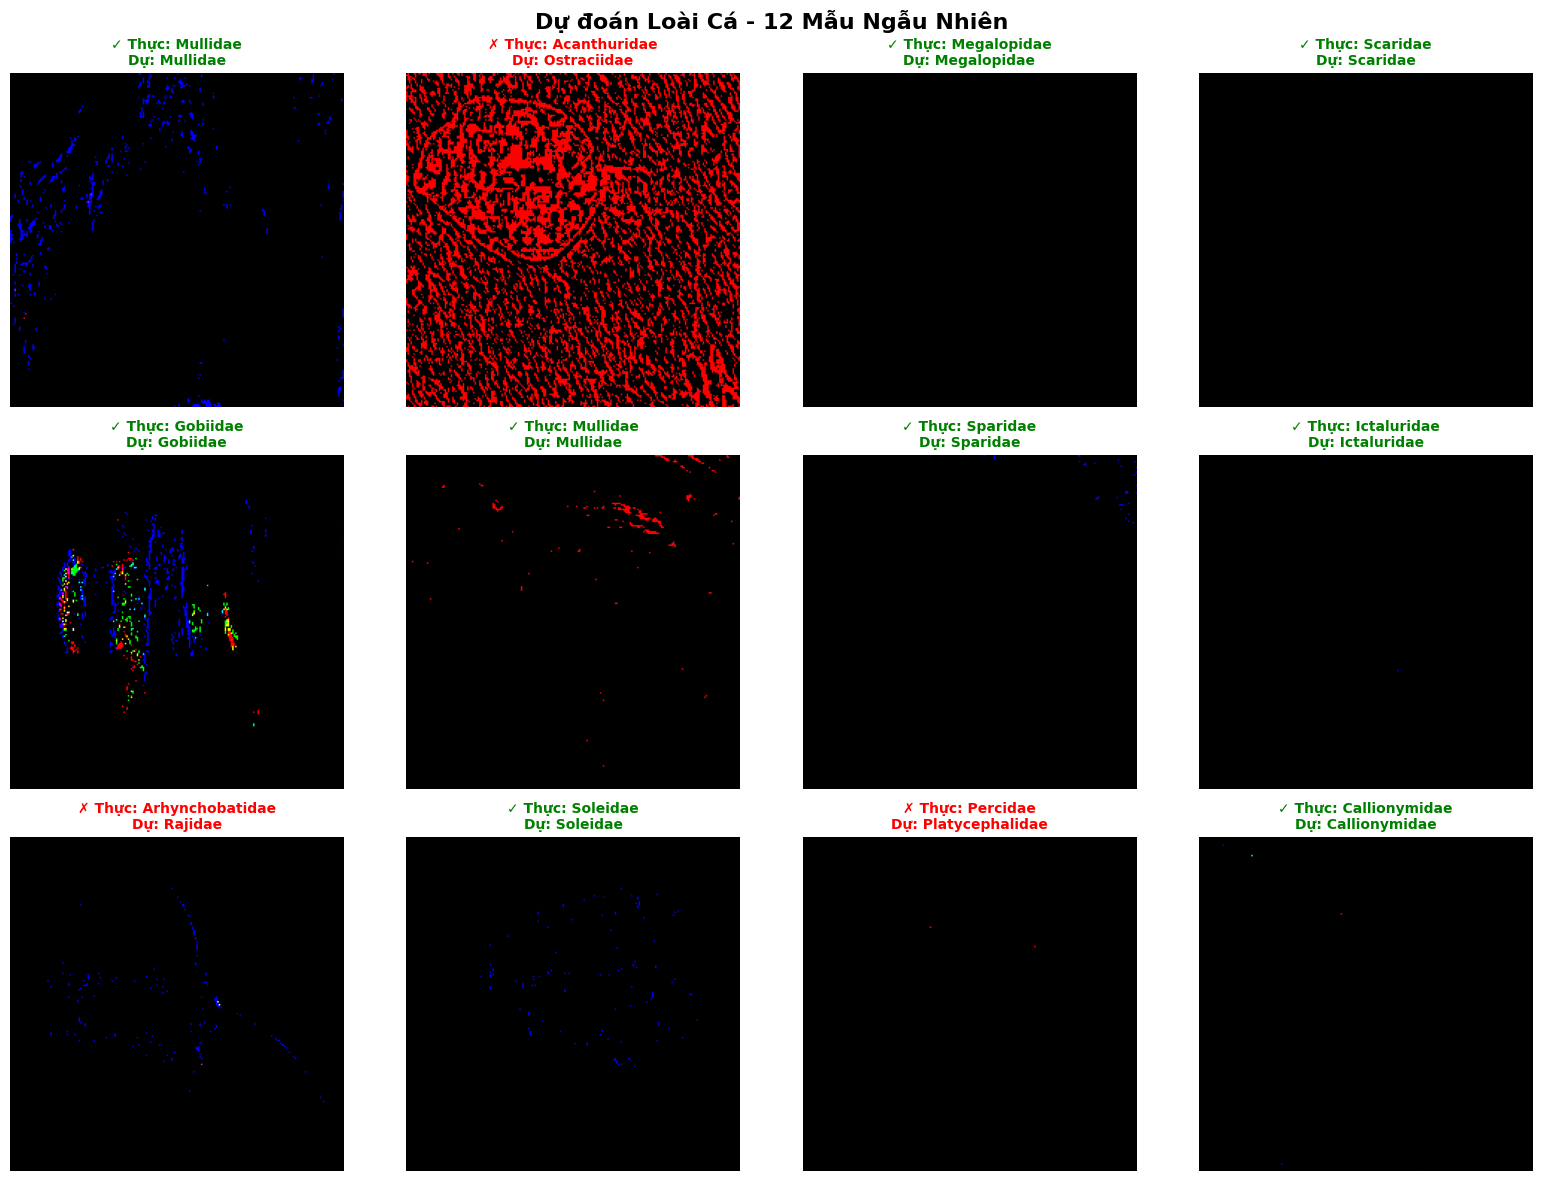


✓ Đúng: 9/12


In [44]:
# ==================== BƯỚC 6: DỰ ĐOÁN CHI TIẾT ====================
# Dự đoán dùng generator (load từng batch)

def predict_with_generator(model, val_generator, label_map):
    """
    Dự đoán trên validation generator để tính metrics chi tiết
    
    Lặp qua tất cả batch, tích luỹ kết quả
    """
    print("\n" + "="*60)
    print("BƯỚC 6: DỰ ĐOÁN CHI TIẾT")
    print("="*60 + "\n")
    
    from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
    
    y_pred_all = []
    y_true_all = []
    X_all = []
    
    # Tính số batch
    num_samples = val_generator.samples
    batch_size = val_generator.batch_size
    val_steps = np.ceil(num_samples / batch_size).astype(int)
    
    print(f"Dự đoán trên {val_steps} batch ({num_samples} mẫu)...")
    
    # Reset generator để từ đầu
    val_generator.reset()
    
    # Lặp qua tất cả batch
    for i in range(val_steps):
        X_batch, y_batch = next(val_generator)
        
        # Dự đoán batch này
        y_pred_batch = model.predict(X_batch, verbose=0)
        y_pred_batch = np.argmax(y_pred_batch, axis=1)
        y_true_batch = np.argmax(y_batch, axis=1)
        
        y_pred_all.extend(y_pred_batch)
        y_true_all.extend(y_true_batch)
        X_all.append(X_batch)
    
    y_pred_all = np.array(y_pred_all)
    y_true_all = np.array(y_true_all)
    X_all = np.concatenate(X_all)
    
    # Tính metrics
    precision = precision_score(y_true_all, y_pred_all, average='weighted', zero_division=0)
    recall = recall_score(y_true_all, y_pred_all, average='weighted', zero_division=0)
    f1 = f1_score(y_true_all, y_pred_all, average='weighted', zero_division=0)
    accuracy = np.mean(y_true_all == y_pred_all)
    
    print(f"\n✓ Kết quả Dự đoán Chi Tiết:")
    print(f"  - Accuracy:  {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall:    {recall:.4f}")
    print(f"  - F1-Score:  {f1:.4f}")
    
    # Per-class metrics
    print(f"\nLớp yếu nhất (Top 10):")
    per_class_recall = recall_score(y_true_all, y_pred_all, average=None, zero_division=0)
    weak_classes = np.argsort(per_class_recall)[:10]
    
    for class_id in weak_classes:
        if class_id in label_map:
            count = np.sum(y_true_all == class_id)
            if count > 0:
                print(f"  {label_map[class_id]:25s} - recall: {per_class_recall[class_id]:.4f} ({count} mẫu)")
    
    cm = confusion_matrix(y_true_all, y_pred_all)
    
    return {
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1,
        'y_pred': y_pred_all, 
        'y_true': y_true_all,
        'cm': cm, 
        'X': X_all,
        'per_class_recall': per_class_recall
    }

def plot_sample_predictions(metrics, label_map, num_samples=12):
    """Hiển thị dự đoán mẫu"""
    print("\n" + "="*60)
    print("BƯỚC 7: HIỂN THỊ SAMPLE PREDICTIONS")
    print("="*60 + "\n")
    
    X_test = metrics['X']
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Dự đoán Loài Cá - 12 Mẫu Ngẫu Nhiên', fontsize=16, fontweight='bold')
    
    correct = 0
    for idx in range(num_samples):
        ax = axes[idx // 4, idx % 4]
        test_idx = np.random.randint(0, len(X_test))
        
        # Hiển thị ảnh
        ax.imshow(X_test[test_idx].astype('uint8'))
        ax.axis('off')
        
        # Lấy thông tin dự đoán
        true_label = metrics['y_true'][test_idx]
        pred_label = metrics['y_pred'][test_idx]
        true_name = label_map.get(true_label, f"Class {true_label}")
        pred_name = label_map.get(pred_label, f"Class {pred_label}")
        is_correct = true_label == pred_label
        
        if is_correct:
            correct += 1
        
        status = "✓" if is_correct else "✗"
        color = 'green' if is_correct else 'red'
        
        title = f"{status} Thực: {true_name}\nDự: {pred_name}"
        ax.set_title(title, fontsize=10, color=color, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Đúng: {correct}/{num_samples}")

# Dự đoán chi tiết
detailed_metrics = predict_with_generator(model_phase1, val_generator, label_map)

# Hiển thị sample predictions
plot_sample_predictions(detailed_metrics, label_map, num_samples=12)

# Trực quan hóa kết quả

BƯỚC 7: TRỰC QUAN HÓA KẾT QUẢ



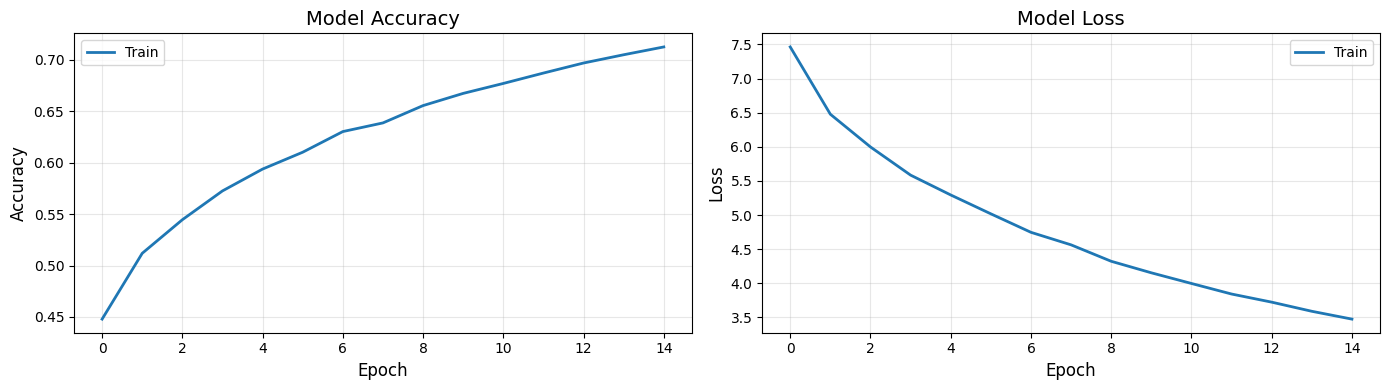

In [48]:
def plot_training_history(history):
    """Vẽ biểu đồ huấn luyện"""
    print("="*60)
    print("BƯỚC 7: TRỰC QUAN HÓA KẾT QUẢ")
    print("="*60 + "\n")

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    # axes[0].plot(history.history['val_accuracy'], label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    # axes[1].plot(history.history['val_loss'], label='Val', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Model Loss', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history_phase2)


PHÂN TÍCH CHI TIẾT VỀ PHÂN LOẠI



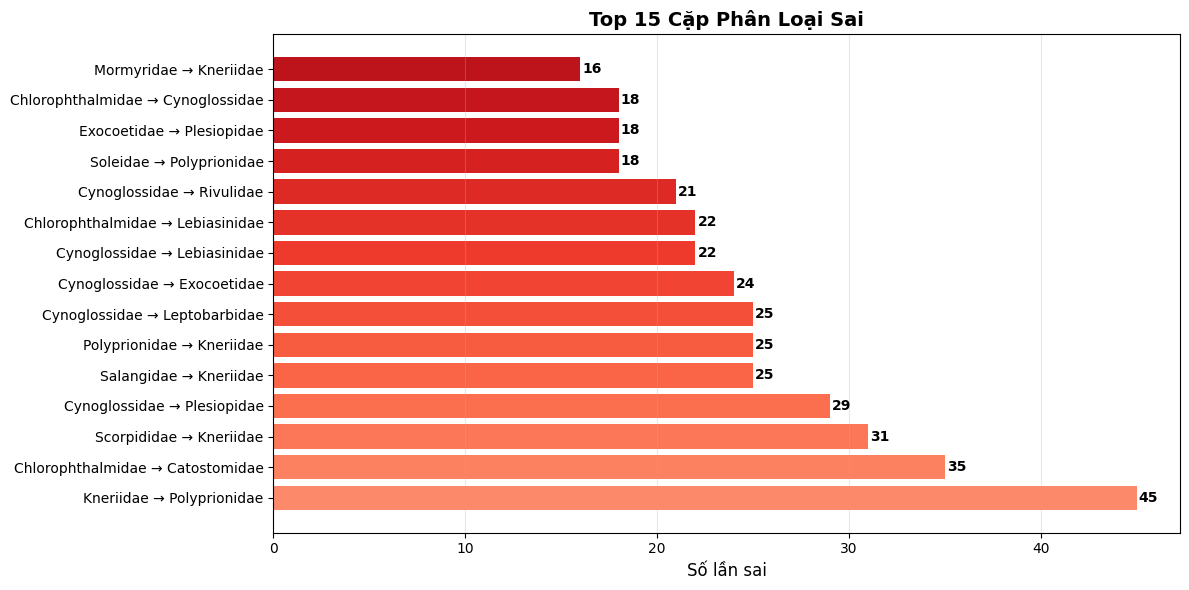

✓ Top 15 confusion pairs



In [58]:
# ==================== VISUALIZATION CHO DỮ LIỆU MẤT CÂN BẰNG 50+ LOÀI ====================

def plot_top_confusion_pairs(metrics, label_map, top_k=15):
    """Hiển thị cặp phân loại sai phổ biến nhất"""
    cm = metrics['cm']

    # Tìm các lỗi phổ biến (loại bỏ đường chéo chính)
    errors = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                errors.append((cm[i, j], label_map[i], label_map[j]))

    if not errors:
        print("\n✓ Không có lỗi phân loại!")
        return

    errors.sort(reverse=True)
    top_errors = errors[:top_k]

    fig, ax = plt.subplots(figsize=(12, 6))

    counts = [e[0] for e in top_errors]
    labels = [f"{e[1]} → {e[2]}" for e in top_errors]

    colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(counts)))
    ax.barh(labels, counts, color=colors)
    ax.set_xlabel('Số lần sai', fontsize=12)
    ax.set_title(f'Top {top_k} Cặp Phân Loại Sai', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    for i, v in enumerate(counts):
        ax.text(v + 0.1, i, str(v), va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
    print(f"✓ Top {top_k} confusion pairs\n")

def plot_per_class_accuracy(metrics, label_map, top_k=20):
    """Hiển thị độ chính xác từng loài"""
    cm = metrics['cm']
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    # Sắp xếp từ thấp lên cao (lớp yếu nhất trước)
    indices = np.argsort(per_class_acc)[:top_k]

    fig, ax = plt.subplots(figsize=(12, 8))
    species = [label_map[i] for i in indices]
    accuracy = per_class_acc[indices]

    colors = ['red' if acc < 0.7 else 'orange' if acc < 0.85 else 'yellow' if acc < 0.95 else 'green'
              for acc in accuracy]
    ax.barh(species, accuracy, color=colors)
    ax.set_xlabel('Recall (Accuracy)', fontsize=12)
    ax.set_title(f'Per-class Recall (Top {top_k} lớp yếu nhất)', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.axvline(x=0.7, color='red', linestyle='--', alpha=0.5, label='70% (Yếu)')
    ax.axvline(x=0.85, color='orange', linestyle='--', alpha=0.5, label='85% (Trung bình)')
    ax.axvline(x=0.95, color='green', linestyle='--', alpha=0.5, label='95% (Tốt)')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3, axis='x')

    for i, v in enumerate(accuracy):
        ax.text(v + 0.02, i, f'{v:.2%}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()
    print(f"✓ Per-class accuracy (Top {top_k})\n")

def plot_data_distribution(y, label_map, top_k=20):
    """Hiển thị phân bố dữ liệu giữa các lớp"""
    unique, counts = np.unique(y, return_counts=True)

    # Lấy top_k lớp có nhiều mẫu nhất
    top_indices = np.argsort(counts)[::-1][:top_k]
    top_labels = [label_map[i] for i in unique[top_indices]]
    top_counts = counts[top_indices]

    fig, ax = plt.subplots(figsize=(12, 6))

    colors = plt.cm.viridis(np.linspace(0, 1, len(top_counts)))
    bars = ax.bar(range(len(top_labels)), top_counts, color=colors)

    ax.set_xlabel('Fish Species', fontsize=12)
    ax.set_ylabel('Số lượng ảnh', fontsize=12)
    ax.set_title(f'Phân bố dữ liệu (Top {top_k} loài)', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(top_labels)))
    ax.set_xticklabels(top_labels, rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

    # Thêm giá trị trên cột
    for i, v in enumerate(top_counts):
        ax.text(i, v + max(top_counts)*0.01, str(v), ha='center', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.show()
    print(f"✓ Data distribution (Top {top_k})\n")

def plot_precision_recall_by_class(metrics, label_map, top_k=15):
    """Vẽ Precision vs Recall cho từng loài"""
    report = classification_report(
        metrics['y_true'], metrics['y_pred'],
        target_names=[label_map[i] for i in range(len(label_map))],
        output_dict=True, zero_division=0
    )

    fig, ax = plt.subplots(figsize=(12, 7))

    species_list = [label_map[i] for i in range(min(top_k, len(label_map)))]
    precisions = [report[s]['precision'] for s in species_list]
    recalls = [report[s]['recall'] for s in species_list]
    f1_scores = [report[s]['f1-score'] for s in species_list]

    scatter = ax.scatter(recalls, precisions, s=200, alpha=0.6, c=f1_scores,
                         cmap='RdYlGn', edgecolors='black', linewidth=1.5)

    for i, species in enumerate(species_list):
        ax.annotate(species, (recalls[i], precisions[i]), fontsize=8,
                   xytext=(5, 5), textcoords='offset points')

    ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax.set_title(f'Precision vs Recall (Top {top_k} Species)', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.set_ylim([0, 1.05])
    ax.grid(True, alpha=0.3)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect F1')
    ax.legend(fontsize=10)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('F1-Score', fontsize=10)

    plt.tight_layout()
    plt.show()
    print(f"✓ Precision vs Recall (Top {top_k})\n")

# Gọi các hàm visualization
print("\n" + "="*60)
print("PHÂN TÍCH CHI TIẾT VỀ PHÂN LOẠI")
print("="*60 + "\n")

plot_top_confusion_pairs(detailed_metrics, label_map, top_k=15)
# plot_per_class_accuracy(detailed_metrics, label_map, top_k=20)
# plot_data_distribution(y, label_map, top_k=20)
# plot_precision_recall_by_class(detailed_metrics, label_map, top_k=15)


PHÂN TÍCH CHI TIẾT VỀ PHÂN LOẠI



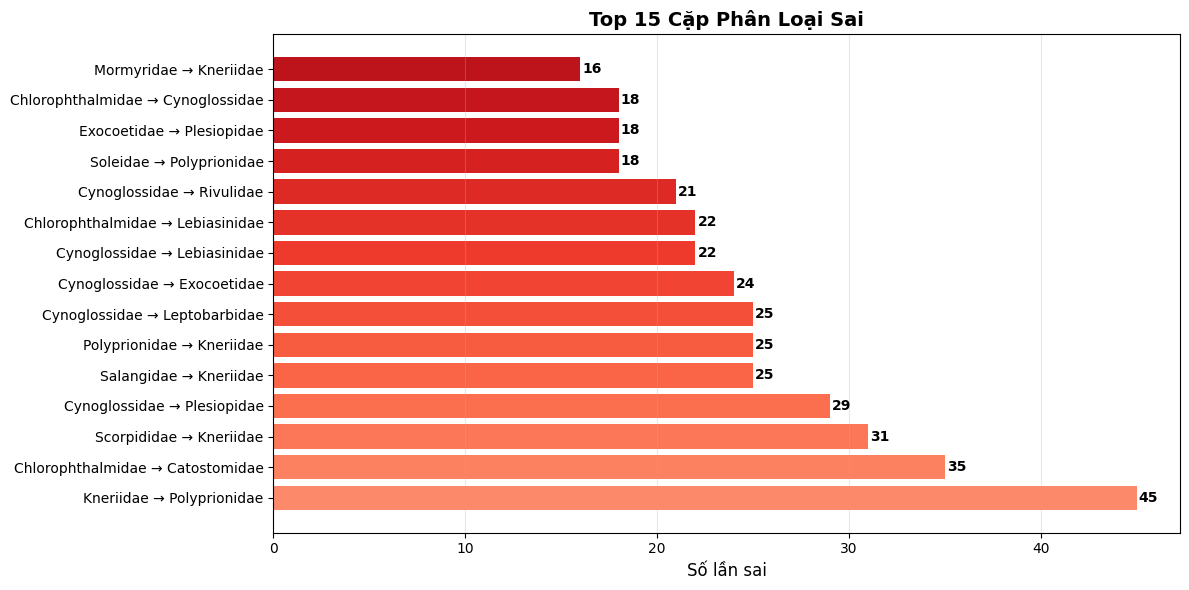

✓ Top 15 confusion pairs



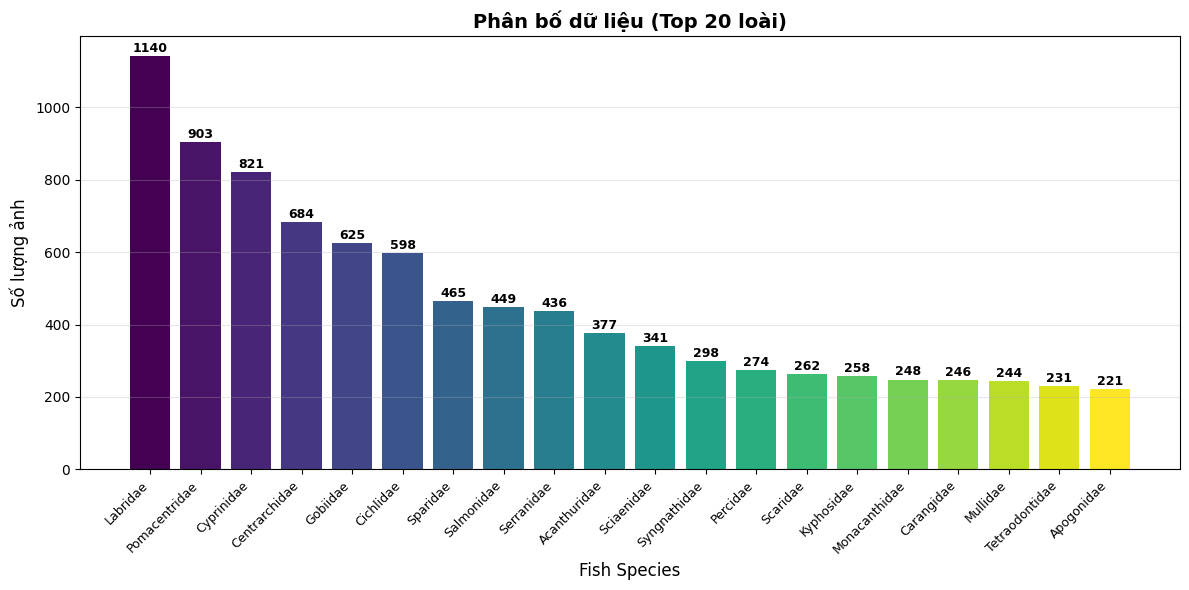

✓ Data distribution (Top 20)



In [64]:
# ==================== VISUALIZATION CHO DỮ LIỆU MẤT CÂN BẰNG 50+ LOÀI ====================

def plot_top_confusion_pairs(metrics, label_map, top_k=15):
    """Hiển thị cặp phân loại sai phổ biến nhất"""
    cm = metrics['cm']

    # Tìm các lỗi phổ biến (loại bỏ đường chéo chính)
    errors = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                errors.append((cm[i, j], label_map[i], label_map[j]))

    if not errors:
        print("\n✓ Không có lỗi phân loại!")
        return

    errors.sort(reverse=True)
    top_errors = errors[:top_k]

    fig, ax = plt.subplots(figsize=(12, 6))

    counts = [e[0] for e in top_errors]
    labels = [f"{e[1]} → {e[2]}" for e in top_errors]

    colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(counts)))
    ax.barh(labels, counts, color=colors)
    ax.set_xlabel('Số lần sai', fontsize=12)
    ax.set_title(f'Top {top_k} Cặp Phân Loại Sai', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    for i, v in enumerate(counts):
        ax.text(v + 0.1, i, str(v), va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
    print(f"✓ Top {top_k} confusion pairs\n")

def plot_per_class_accuracy(metrics, label_map, top_k=20):
    """Hiển thị độ chính xác từng loài"""
    cm = metrics['cm']
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    # Sắp xếp từ thấp lên cao (lớp yếu nhất trước)
    indices = np.argsort(per_class_acc)[:top_k]

    fig, ax = plt.subplots(figsize=(12, 8))
    species = [label_map[i] for i in indices]
    accuracy = per_class_acc[indices]

    colors = ['red' if acc < 0.7 else 'orange' if acc < 0.85 else 'yellow' if acc < 0.95 else 'green'
              for acc in accuracy]
    ax.barh(species, accuracy, color=colors)
    ax.set_xlabel('Recall (Accuracy)', fontsize=12)
    ax.set_title(f'Per-class Recall (Top {top_k} lớp yếu nhất)', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.axvline(x=0.7, color='red', linestyle='--', alpha=0.5, label='70% (Yếu)')
    ax.axvline(x=0.85, color='orange', linestyle='--', alpha=0.5, label='85% (Trung bình)')
    ax.axvline(x=0.95, color='green', linestyle='--', alpha=0.5, label='95% (Tốt)')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3, axis='x')

    for i, v in enumerate(accuracy):
        ax.text(v + 0.02, i, f'{v:.2%}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()
    print(f"✓ Per-class accuracy (Top {top_k})\n")

def plot_data_distribution(y, label_map, top_k=20):
    """Hiển thị phân bố dữ liệu giữa các lớp"""
    unique, counts = np.unique(y, return_counts=True)

    # Lấy top_k lớp có nhiều mẫu nhất
    top_indices = np.argsort(counts)[::-1][:top_k]
    top_labels = [label_map[i] for i in unique[top_indices]]
    top_counts = counts[top_indices]
    fig, ax = plt.subplots(figsize=(12, 6))

    colors = plt.cm.viridis(np.linspace(0, 1, len(top_counts)))
    bars = ax.bar(range(len(top_labels)), top_counts, color=colors)

    ax.set_xlabel('Fish Species', fontsize=12)
    ax.set_ylabel('Số lượng ảnh', fontsize=12)
    ax.set_title(f'Phân bố dữ liệu (Top {top_k} loài)', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(top_labels)))
    ax.set_xticklabels(top_labels, rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

    # Thêm giá trị trên cột
    for i, v in enumerate(top_counts):
        ax.text(i, v + max(top_counts)*0.01, str(v), ha='center', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.show()
    print(f"✓ Data distribution (Top {top_k})\n")

def plot_precision_recall_by_class(metrics, label_map, top_k=15):
    """Vẽ Precision vs Recall cho từng loài"""
    # Tìm số lớp thực tế từ predictions
    num_classes = max(metrics['y_pred'].max(), metrics['y_true'].max()) + 1
    
    # Lọc label_map chỉ giữ lại các lớp có trong dữ liệu
    valid_label_map = {i: label_map.get(i, f"Class {i}") for i in range(num_classes)}
    
    report = classification_report(
        metrics['y_true'], metrics['y_pred'],
        labels=list(range(num_classes)),
        target_names=[valid_label_map[i] for i in range(num_classes)],
        output_dict=True, zero_division=0
    )

    fig, ax = plt.subplots(figsize=(12, 7))

    # Lấy top_k loài với F1-score cao nhất
    species_f1 = [(valid_label_map[i], report[valid_label_map[i]]['f1-score'], i) 
                  for i in range(num_classes)]
    species_f1.sort(key=lambda x: x[1], reverse=True)
    top_species = species_f1[:top_k]
    
    species_list = [s[0] for s in top_species]
    precisions = [report[s]['precision'] for s in species_list]
    recalls = [report[s]['recall'] for s in species_list]
    f1_scores = [report[s]['f1-score'] for s in species_list]

    scatter = ax.scatter(recalls, precisions, s=200, alpha=0.6, c=f1_scores,
                         cmap='RdYlGn', edgecolors='black', linewidth=1.5)

    for i, species in enumerate(species_list):
        ax.annotate(species, (recalls[i], precisions[i]), fontsize=8,
                   xytext=(5, 5), textcoords='offset points')

    ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax.set_title(f'Precision vs Recall (Top {top_k} Species)', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.set_ylim([0, 1.05])
    ax.grid(True, alpha=0.3)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect F1')
    ax.legend(fontsize=10)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('F1-Score', fontsize=10)

    plt.tight_layout()
    plt.show()
    print(f"✓ Precision vs Recall (Top {top_k})\n")

# Gọi các hàm visualization
print("\n" + "="*60)
print("PHÂN TÍCH CHI TIẾT VỀ PHÂN LOẠI")
print("="*60 + "\n")

plot_top_confusion_pairs(detailed_metrics, label_map, top_k=15)
# plot_per_class_accuracy(detailed_metrics, label_map, top_k=20)
plot_data_distribution(detailed_metrics['y_true'], label_map, top_k=20)
# plot_precision_recall_by_class(detailed_metrics, label_map, top_k=15)

# Lưu mô hình

In [55]:
# ==================== BƯỚC 8: LƯU MÔ HÌNH ====================

def save_model_and_labels(model, label_map, model_dir="./models", model_name="fish_classifier"):
    """Lưu mô hình và label_map"""
    print("="*60)
    print("BƯỚC 8: LƯU MÔ HÌNH")
    print("="*60 + "\n")

    os.makedirs(model_dir, exist_ok=True)

    # Lưu mô hình
    model_path = os.path.join(model_dir, f"{model_name}_model.keras")
    model.save(model_path)
    print(f"✓ Model: {model_path}")

    # Lưu label_map
    label_path = os.path.join(model_dir, f"{model_name}_labels.json")
    label_map_str = {str(k): v for k, v in label_map.items()}
    with open(label_path, 'w', encoding='utf-8') as f:
        json.dump(label_map_str, f, ensure_ascii=False, indent=2)
    print(f"✓ Labels: {label_path}")

    return model_path, label_path

model_path, label_path = save_model_and_labels(model_phase1, label_map)

BƯỚC 8: LƯU MÔ HÌNH

✓ Model: ./models/fish_classifier_model.keras
✓ Labels: ./models/fish_classifier_labels.json
